# Baseline for MINILEAVES Challenge on AIcrowd
#### Author : Gaétan Ramet

## Download Necessary Packages

In [1]:
#Donwload the datasets
#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt
#!pip install efficientnet_pytorch

!nvidia-smi

Wed May 13 17:05:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  


## Import packages

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import os
import cv2
import tqdm
from sklearn import preprocessing
from sklearn.metrics import f1_score,precision_score,log_loss, classification_report 
%matplotlib inline


## Load Data

In [3]:
train_images_path = "train-images.npy" #path where data is stored
train_labels_path = "train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)
print(train_images.shape)
# Load Class mapping
class_names = [x.strip() for x in open("all_classes.txt").readlines()]

class LeaveData(Dataset):
    def __init__(self,data_mat, labels, transform=None,train=True):
        super().__init__()
        self.data_mat = data_mat
        self.labels = labels
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_mat.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img, label = self.data_mat[item], self.labels[item]
        else:
          img = self.data_mat[item]
        img = cv2.resize(img,(256,256))
        if self.transform is not None:
            img = self.transform(img)
        if self.train:
          return {
              'gt' : img,
              'label' : torch.tensor(label)

          }
        else:
          return {
              'gt':img
          }

(43466, 32, 32, 3)


In [0]:
input_size = 224
batch_size = 64
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=180, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])
train_data = LeaveData(data_mat=train_images, labels=train_labels, transform = transforms_train)

transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))

])
test_path = 'test-images.npy'
test = np.load(test_path)
test_data = LeaveData(data_mat=test, labels=None, transform = transforms_test,train=False)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


## Visualize the data

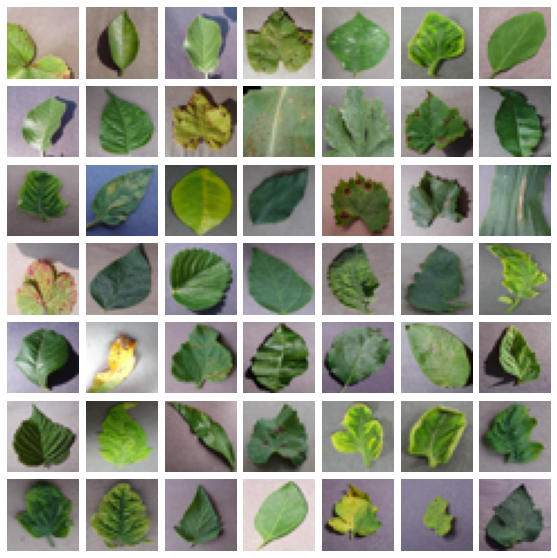

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    global class_name, train_images, train_labels
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name

"""
Render a 7x7 grid of 49 randomly sampled images
from the training set
"""
grid_shape = (7, 7)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=grid_shape,  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

data_samples = [random_data_sample() for _ in range(grid_shape[0] * grid_shape[1])]
for ax, data_sample in zip(grid, data_samples):
    image_array, class_label, class_name = data_sample
    ax.imshow(image_array)
    ax.axis('off')

plt.savefig("image-grid.png")

# Dataset Distribution

In [6]:
from collections import Counter

data_counter = Counter(train_labels)
unique_class_indices = data_counter.keys()

for _class_index in unique_class_indices:
    print("Class Index : ", _class_index)
    print("Class Name : ", class_names[_class_index])
    print("Number of images in the dataset : ", data_counter[_class_index])
    print("="*100)
print(len(unique_class_indices))
# TODO : Add a bar plot of the distribution of the classes here

Class Index :  7
Class Name :  corn-maize-cercospora-leaf-spot-gray-leaf-spot
Number of images in the dataset :  410
Class Index :  4
Class Name :  blueberry-healthy
Number of images in the dataset :  1205
Class Index :  9
Class Name :  corn-maize-healthy
Number of images in the dataset :  925
Class Index :  29
Class Name :  tomato-early-blight
Number of images in the dataset :  806
Class Index :  20
Class Name :  potato-early-blight
Number of images in the dataset :  808
Class Index :  15
Class Name :  orange-haunglongbing-citrus-greening
Number of images in the dataset :  4422
Class Index :  37
Class Name :  tomato-tomato-yellow-leaf-curl-virus
Number of images in the dataset :  4238
Class Index :  5
Class Name :  cherry-including-sour-healthy
Number of images in the dataset :  666
Class Index :  28
Class Name :  tomato-bacterial-spot
Number of images in the dataset :  1738
Class Index :  16
Class Name :  peach-bacterial-spot
Number of images in the dataset :  1864
Class Index :  14


## Split Data into Train and Validation
Now we eventually want to see how well our classifier is performing, but we dont have the test data labels with us to check.
What do we do ? We split our dataset into a training set and a validation set. The idea is that we test our classifier on validation set in order to get an idea of how well our classifier works. This way we can also ensure that we dont [overfit](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/) on the training dataset. 

In [0]:
#batch = 256
valid_size = 0.2
num = train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)

Here we have selected the size of the testing data to be 20% of the total data. You can change it and see what effect it has on the accuracies. To learn more about the train_test_split function [click here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

## Define the Classifier
Now we come to the juicy part. We have fixed our data and now we train a classifier. The classifier will learn the function by looking at the inputs and corresponding outputs. There are a ton of classifiers to choose from some being [Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), [SVM](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47), [Random Forests](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47), [Decision Trees](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052), etc.   
Tip: A good model doesnt depend solely on the classifier but on the features(columns) you choose. So make sure to play with your data and keep only whats important. 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_extract = False

from torch.optim import lr_scheduler

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


class Net(nn.Module):
  # Define layers here
    def __init__(self, feature_extract=True):
        super(Net, self).__init__()
        #self.resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet = EfficientNet.from_pretrained("efficientnet-b0", advprop=False)
        #num_ftrs = self.resnet.fc.in_features
        num_ftrs = self.resnet._fc.in_features
        set_parameter_requires_grad(self.resnet, feature_extracting=feature_extract)
        #self.resnet.fc = nn.Linear(num_ftrs, 38)
        self.resnet._fc = nn.Linear(num_ftrs, 38)


    def forward(self, x):
      # Forward pass
        return self.resnet(x)

model = Net(feature_extract).to(device)
class_weight = torch.zeros(len(unique_class_indices))
nums = data_counter.values()
for cl in unique_class_indices:
    class_weight[cl] = max(nums) / data_counter[cl]
error = nn.CrossEntropyLoss(weight=class_weight).to(device)

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = optim.Adam(params_to_update)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Loaded pretrained weights for efficientnet-b0
Params to learn:
	 resnet._conv_stem.weight
	 resnet._bn0.weight
	 resnet._bn0.bias
	 resnet._blocks.0._depthwise_conv.weight
	 resnet._blocks.0._bn1.weight
	 resnet._blocks.0._bn1.bias
	 resnet._blocks.0._se_reduce.weight
	 resnet._blocks.0._se_reduce.bias
	 resnet._blocks.0._se_expand.weight
	 resnet._blocks.0._se_expand.bias
	 resnet._blocks.0._project_conv.weight
	 resnet._blocks.0._bn2.weight
	 resnet._blocks.0._bn2.bias
	 resnet._blocks.1._expand_conv.weight
	 resnet._blocks.1._bn0.weight
	 resnet._blocks.1._bn0.bias
	 resnet._blocks.1._depthwise_conv.weight
	 resnet._blocks.1._bn1.weight
	 resnet._blocks.1._bn1.bias
	 resnet._blocks.1._se_reduce.weight
	 resnet._blocks.1._se_reduce.bias
	 resnet._blocks.1._se_expand.weight
	 resnet._blocks.1._se_expand.bias
	 resnet._blocks.1._project_conv.weight
	 resnet._blocks.1._bn2.weight
	 resnet._blocks.1._bn2.bias
	 resnet._blocks.2._expand_conv.weight
	 resnet._blocks.2._bn0.weight
	 resnet.

We have used a very simple [Multi Layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) as a classifier here and set few of the parameteres. But one can set more parameters and increase the performance. To see the list of parameters visit [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

We can also use other classifiers. To read more about sklean classifiers visit [here](https://scikit-learn.org/stable/supervised_learning.html). Try and use other classifiers to see how the performance of your model changes. Try using [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) or [MLP](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) and compare how the performance changes.

## Train the classifier

In [9]:
n_epochs = 20
valid_loss_min = np.Inf


train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for images in tqdm.tqdm(train_loader):
        data = images['gt'].squeeze(0).to(device)
        # data = data.squeeze(0)
        target = images['label'].to(device)
#             clear the gradients of all optimized variables
        optimizer.zero_grad()
#         forward pass the model
        output = model(data)
#     backward pass the model
        loss = error(output,target)
        loss.backward()
#         Perform a single optimization step
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    exp_lr_scheduler.step()
        
    
    
    
    model.eval()
    pred_list = []
    correct_list = []
    for images in tqdm.tqdm(valid_loader):
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
#         forward pass now
        output = model(data)        
        _, predicted = torch.max(output.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
          correct_list.append(i)
#         calculate the branch loss
        loss = error(output, target)
#     update average validation loss
        valid_loss += loss.item()*data.size(0)
    
    train_loss /= len(train_loader.sampler)
    valid_loss /= len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    F1_val = f1_score(correct_list,pred_list,average='micro')
    print(classification_report(correct_list, pred_list))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation F1: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_val))
    
    if epoch >= 10:
      torch.save(model.state_dict(), 'model_epoch{}.pth'.format(epoch))
    if valid_loss <= valid_loss_min:
        print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'best_model_so_far.pth')

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       110
           1       0.96      0.72      0.82       109
           2       0.76      0.89      0.82        46
           3       0.77      0.87      0.82       255
           4       0.74      0.98      0.84       261
           5       0.97      0.90      0.93       118
           6       0.88      0.86      0.87       175
           7       0.83      0.80      0.81        71
           8       0.98      0.95      0.96       182
           9       0.99      0.97      0.98       196
          10       0.87      0.90      0.89       157
          11       0.97      0.80      0.88       196
          12       0.80      0.98      0.88       224
          13       0.87      0.88      0.87        74
          14       0.89      0.96      0.92       162
          15       0.97      0.96      0.96       884
          16       0.95      0.79      0.86       377
          17       0.77    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.66      0.80       110
           1       0.78      0.90      0.83       109
           2       0.48      0.98      0.65        46
           3       0.77      0.88      0.82       255
           4       1.00      0.64      0.78       261
           5       0.83      0.96      0.89       118
           6       0.88      0.88      0.88       175
           7       0.73      0.75      0.74        71
           8       0.95      0.97      0.96       182
           9       0.81      1.00      0.89       196
          10       0.91      0.80      0.85       157
          11       0.95      0.80      0.86       196
          12       0.84      0.97      0.90       224
          13       0.90      0.64      0.75        74
          14       0.81      0.90      0.85       162
          15       0.98      0.94      0.96       884
          16       0.90      0.80      0.85       377
          17       0.63    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       110
           1       0.89      0.94      0.91       109
           2       0.69      0.93      0.80        46
           3       0.94      0.81      0.87       255
           4       0.89      0.97      0.93       261
           5       0.97      0.97      0.97       118
           6       0.86      0.95      0.90       175
           7       0.89      0.72      0.80        71
           8       0.99      0.98      0.99       182
           9       0.99      0.97      0.98       196
          10       0.87      0.94      0.91       157
          11       0.86      0.97      0.91       196
          12       0.96      0.94      0.95       224
          13       0.98      0.85      0.91        74
          14       0.92      0.93      0.92       162
          15       0.98      0.98      0.98       884
          16       0.99      0.88      0.93       377
          17       0.86    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       110
           1       0.89      0.93      0.91       109
           2       0.82      1.00      0.90        46
           3       0.92      0.89      0.90       255
           4       0.97      0.93      0.95       261
           5       0.99      0.89      0.94       118
           6       0.98      0.95      0.96       175
           7       0.68      0.87      0.77        71
           8       0.98      0.96      0.97       182
           9       0.95      0.99      0.97       196
          10       0.92      0.85      0.88       157
          11       0.92      0.97      0.95       196
          12       0.99      0.95      0.97       224
          13       0.78      0.99      0.87        74
          14       0.87      0.98      0.92       162
          15       0.98      0.98      0.98       884
          16       0.90      0.97      0.93       377
          17       0.78    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       110
           1       0.87      0.94      0.91       109
           2       0.81      0.96      0.88        46
           3       0.90      0.91      0.91       255
           4       0.95      0.95      0.95       261
           5       0.70      0.96      0.81       118
           6       0.94      0.95      0.94       175
           7       0.70      0.96      0.81        71
           8       0.98      0.97      0.98       182
           9       0.98      0.99      0.98       196
          10       0.95      0.81      0.88       157
          11       0.98      0.70      0.82       196
          12       0.83      0.99      0.90       224
          13       0.95      0.80      0.87        74
          14       0.99      0.93      0.96       162
          15       0.99      0.95      0.97       884
          16       0.97      0.85      0.91       377
          17       0.92    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       110
           1       0.95      0.97      0.96       109
           2       0.94      1.00      0.97        46
           3       0.97      0.94      0.96       255
           4       0.97      1.00      0.98       261
           5       0.95      0.99      0.97       118
           6       0.98      0.99      0.99       175
           7       0.85      0.96      0.90        71
           8       0.97      0.99      0.98       182
           9       1.00      1.00      1.00       196
          10       0.97      0.90      0.93       157
          11       0.98      0.98      0.98       196
          12       0.99      0.98      0.99       224
          13       0.86      0.95      0.90        74
          14       0.96      1.00      0.98       162
          15       1.00      0.99      0.99       884
          16       0.97      0.97      0.97       377
          17       0.90    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       110
           1       0.93      0.97      0.95       109
           2       0.98      1.00      0.99        46
           3       0.96      0.97      0.96       255
           4       0.98      0.98      0.98       261
           5       0.97      0.97      0.97       118
           6       0.99      0.98      0.99       175
           7       0.81      0.97      0.88        71
           8       0.97      1.00      0.99       182
           9       1.00      0.99      1.00       196
          10       0.97      0.89      0.93       157
          11       0.98      0.98      0.98       196
          12       1.00      0.99      0.99       224
          13       0.92      0.99      0.95        74
          14       0.98      0.98      0.98       162
          15       1.00      0.99      0.99       884
          16       0.99      0.98      0.98       377
          17       0.78    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       110
           1       0.93      0.98      0.96       109
           2       0.91      0.93      0.92        46
           3       0.99      0.96      0.97       255
           4       0.97      0.98      0.98       261
           5       0.95      0.98      0.97       118
           6       0.97      1.00      0.98       175
           7       0.87      0.92      0.89        71
           8       0.98      1.00      0.99       182
           9       0.99      0.99      0.99       196
          10       0.96      0.95      0.96       157
          11       0.98      0.97      0.98       196
          12       0.99      0.99      0.99       224
          13       0.93      1.00      0.96        74
          14       0.98      0.99      0.98       162
          15       1.00      0.99      1.00       884
          16       0.98      0.96      0.97       377
          17       0.94    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       110
           1       0.97      0.98      0.98       109
           2       0.90      1.00      0.95        46
           3       0.98      0.97      0.98       255
           4       0.97      0.98      0.98       261
           5       0.96      0.97      0.97       118
           6       0.98      0.98      0.98       175
           7       0.85      0.97      0.91        71
           8       0.99      0.99      0.99       182
           9       1.00      0.99      0.99       196
          10       0.98      0.92      0.95       157
          11       0.96      0.96      0.96       196
          12       1.00      0.97      0.98       224
          13       0.94      0.99      0.96        74
          14       0.99      0.98      0.98       162
          15       1.00      0.99      0.99       884
          16       0.99      0.97      0.98       377
          17       0.89    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       110
           1       0.98      0.99      0.99       109
           2       0.98      0.96      0.97        46
           3       0.98      0.95      0.97       255
           4       0.99      1.00      0.99       261
           5       0.96      0.99      0.97       118
           6       0.98      0.99      0.99       175
           7       0.88      0.89      0.88        71
           8       0.96      0.99      0.98       182
           9       0.99      1.00      1.00       196
          10       0.95      0.93      0.94       157
          11       0.98      0.98      0.98       196
          12       1.00      0.99      0.99       224
          13       0.97      0.97      0.97        74
          14       0.98      0.99      0.98       162
          15       1.00      0.99      0.99       884
          16       0.99      0.98      0.99       377
          17       0.90    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       110
           1       0.95      0.97      0.96       109
           2       0.98      1.00      0.99        46
           3       0.99      0.98      0.98       255
           4       0.98      0.98      0.98       261
           5       0.95      0.97      0.96       118
           6       0.99      0.97      0.98       175
           7       0.88      0.93      0.90        71
           8       0.96      1.00      0.98       182
           9       1.00      0.98      0.99       196
          10       0.98      0.92      0.95       157
          11       0.97      0.97      0.97       196
          12       0.99      0.98      0.99       224
          13       0.92      0.99      0.95        74
          14       0.99      0.98      0.98       162
          15       1.00      0.99      1.00       884
          16       0.98      0.98      0.98       377
          17       0.82    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       110
           1       0.96      0.99      0.98       109
           2       0.96      0.98      0.97        46
           3       0.97      0.98      0.98       255
           4       0.99      0.99      0.99       261
           5       0.98      0.99      0.99       118
           6       0.99      0.99      0.99       175
           7       0.91      0.94      0.92        71
           8       0.97      1.00      0.99       182
           9       0.99      0.99      0.99       196
          10       0.97      0.94      0.95       157
          11       0.98      0.97      0.98       196
          12       0.99      0.99      0.99       224
          13       0.95      1.00      0.97        74
          14       0.98      1.00      0.99       162
          15       1.00      0.99      0.99       884
          16       0.98      0.97      0.98       377
          17       0.92    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       110
           1       0.94      0.96      0.95       109
           2       0.94      0.98      0.96        46
           3       0.98      0.96      0.97       255
           4       0.99      0.99      0.99       261
           5       0.97      0.98      0.98       118
           6       0.99      0.99      0.99       175
           7       0.89      0.94      0.92        71
           8       0.97      0.99      0.98       182
           9       0.99      1.00      1.00       196
          10       0.97      0.94      0.95       157
          11       0.96      0.98      0.97       196
          12       0.99      0.97      0.98       224
          13       0.99      1.00      0.99        74
          14       0.96      0.99      0.98       162
          15       1.00      0.99      1.00       884
          16       0.97      0.97      0.97       377
          17       0.92    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       110
           1       0.96      1.00      0.98       109
           2       0.92      0.98      0.95        46
           3       0.98      0.97      0.97       255
           4       0.98      1.00      0.99       261
           5       0.99      0.99      0.99       118
           6       0.98      0.97      0.97       175
           7       0.87      0.93      0.90        71
           8       0.98      0.99      0.99       182
           9       0.99      0.99      0.99       196
          10       0.95      0.91      0.93       157
          11       0.99      0.98      0.99       196
          12       1.00      0.99      0.99       224
          13       0.94      0.99      0.96        74
          14       0.99      1.00      0.99       162
          15       1.00      0.99      0.99       884
          16       0.99      0.98      0.99       377
          17       0.89    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       110
           1       0.93      0.97      0.95       109
           2       1.00      0.98      0.99        46
           3       0.97      0.98      0.98       255
           4       0.98      0.99      0.99       261
           5       0.97      0.97      0.97       118
           6       0.99      0.99      0.99       175
           7       0.89      0.96      0.93        71
           8       0.98      0.99      0.99       182
           9       0.99      0.99      0.99       196
          10       0.97      0.94      0.95       157
          11       0.98      0.98      0.98       196
          12       0.99      0.99      0.99       224
          13       0.95      1.00      0.97        74
          14       0.98      0.99      0.99       162
          15       1.00      0.99      1.00       884
          16       0.99      0.97      0.98       377
          17       0.89    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       110
           1       0.98      0.99      0.99       109
           2       0.92      0.98      0.95        46
           3       0.98      0.98      0.98       255
           4       0.98      0.98      0.98       261
           5       0.97      0.99      0.98       118
           6       0.98      0.99      0.99       175
           7       0.88      0.96      0.92        71
           8       0.98      0.99      0.99       182
           9       0.99      0.99      0.99       196
          10       0.98      0.93      0.95       157
          11       0.98      0.98      0.98       196
          12       1.00      1.00      1.00       224
          13       0.97      0.99      0.98        74
          14       0.98      0.99      0.99       162
          15       1.00      1.00      1.00       884
          16       0.98      0.96      0.97       377
          17       0.90    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       110
           1       0.94      0.99      0.96       109
           2       0.88      0.98      0.93        46
           3       0.98      0.98      0.98       255
           4       0.99      0.99      0.99       261
           5       0.97      0.98      0.98       118
           6       0.99      0.99      0.99       175
           7       0.85      0.94      0.89        71
           8       0.99      0.99      0.99       182
           9       1.00      0.99      1.00       196
          10       0.97      0.94      0.95       157
          11       0.98      0.98      0.98       196
          12       1.00      0.99      0.99       224
          13       0.96      0.99      0.97        74
          14       0.99      0.99      0.99       162
          15       1.00      1.00      1.00       884
          16       0.99      0.97      0.98       377
          17       0.87    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       110
           1       0.94      0.98      0.96       109
           2       0.96      0.98      0.97        46
           3       0.98      0.98      0.98       255
           4       0.98      0.98      0.98       261
           5       0.97      0.98      0.97       118
           6       0.99      0.99      0.99       175
           7       0.86      0.93      0.89        71
           8       0.99      0.98      0.99       182
           9       0.99      1.00      1.00       196
          10       0.95      0.95      0.95       157
          11       0.99      0.98      0.98       196
          12       0.98      0.99      0.98       224
          13       0.96      0.99      0.97        74
          14       0.99      0.99      0.99       162
          15       1.00      0.99      1.00       884
          16       0.98      0.99      0.99       377
          17       0.92    

  0%|          | 0/544 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       110
           1       0.96      0.98      0.97       109
           2       0.96      0.98      0.97        46
           3       0.99      0.97      0.98       255
           4       0.98      0.99      0.98       261
           5       0.98      0.98      0.98       118
           6       0.98      0.99      0.99       175
           7       0.87      0.93      0.90        71
           8       0.99      1.00      1.00       182
           9       1.00      1.00      1.00       196
          10       0.95      0.94      0.95       157
          11       0.98      0.96      0.97       196
          12       0.99      0.98      0.98       224
          13       0.96      1.00      0.98        74
          14       0.98      0.99      0.98       162
          15       1.00      0.99      1.00       884
          16       0.99      0.97      0.98       377
          17       0.89    

100%|██████████| 136/136 [00:27<00:00,  4.94it/s]


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       110
           1       0.95      0.99      0.97       109
           2       0.94      0.96      0.95        46
           3       0.99      0.98      0.98       255
           4       0.98      0.99      0.99       261
           5       0.95      0.99      0.97       118
           6       0.98      0.98      0.98       175
           7       0.85      0.99      0.92        71
           8       0.98      0.99      0.99       182
           9       0.99      1.00      1.00       196
          10       0.98      0.94      0.96       157
          11       0.97      0.98      0.98       196
          12       1.00      0.98      0.99       224
          13       0.95      0.99      0.97        74
          14       0.98      1.00      0.99       162
          15       1.00      0.99      1.00       884
          16       0.99      0.97      0.98       377
          17       0.87    

## Predict on Validation
Now we predict our trained classifier on the validation set and evaluate our model

In [10]:
#model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()
correct = 0
total = 0
pred_list = []
correct_list = []
with torch.no_grad():
    for images in valid_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
          correct_list.append(i)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97.699298 %


## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[F1 score](https://en.wikipedia.org/wiki/F1_score) and [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) are the metrics for this challenge

In [11]:
from sklearn.metrics import f1_score,precision_score,log_loss   
print("F1 score :",f1_score(correct_list,pred_list,average='micro'))

F1 score : 0.9769929828597722


# Prediction on Evaluation Set

## Load Test Set

In [0]:
test_file_path = "test-images.npy"
test_images = np.load(test_file_path)

## Predict Test Set
The moment of truth! Predict on test set and then we can make the submission.

In [0]:
import pandas as pd

submissions = []
for sub in range(10, 20):
    model.load_state_dict(torch.load('model_epoch{}.pth'.format(sub)))
    model.eval()

    submission = []
    with torch.no_grad():
        for images in test_loader:
            data = images['gt'].squeeze(0).to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            pr = predicted.detach().cpu().numpy()
            for i in pr:
              submission.append(i)
        submission = pd.DataFrame(submission)
        submission.to_csv('submission_epoch{}.csv'.format(sub),header=['class_index'],index=False)
        submissions.append(submission)

## Save the prediction to csv

In [0]:
#change the header according to the submission guidelines

In [0]:
submission_voting = pd.concat(submissions, axis=1, sort=False)
submission_voting['majority'] = submission_voting.mode(axis=1)[0]
sub_v_df = pd.DataFrame(list(submission_voting['majority'].apply(int).values))
sub_v_df.to_csv('submission_voting.csv',header=['class_index'],index=False)


Note: Do take a look at the submission format.The submission file should contain a header.